# Set-up Environment

In [1]:
spark.version

'3.1.3'

In [2]:
import os
import pandas as pd
import numpy as np

from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
warnings.filterwarnings(action = 'ignore')

In [3]:
!pip3 install nltk -U

In [4]:
import re
import json
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer, IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from google.cloud import storage

spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

## Set-up COS functions for GCP

In [6]:
# List all files in given COS directory
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix = folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns = ['Name','Size'])

    #blobs_df = blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [7]:
# Delete folder from COS bucket
def delete_folder(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix = folder_name))

    for blob in blobs:
        blob.delete()

In [8]:
# Reading data from bucket
bucket = 'shijia-bdp-class'

# Read Filtered Data Parquet Files

In [9]:
blob_list = list_blobs_pd(bucket, 'inter_result/filtered')

In [10]:
blob_list.head(10)

,Name,Size
0,inter_result/filtered/,0
1,inter_result/filtered/_SUCCESS,0
2,inter_result/filtered/part-00000-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,79905281
3,inter_result/filtered/part-00001-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,79675239
4,inter_result/filtered/part-00002-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,79120751
5,inter_result/filtered/part-00003-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,78856771
6,inter_result/filtered/part-00004-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,78841226
7,inter_result/filtered/part-00005-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,78763533
8,inter_result/filtered/part-00006-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,78783569
9,inter_result/filtered/part-00007-72d3cf21-ad17-47aa-8047-96bad2115411-c000.snappy.parquet,78734456


In [11]:
path = 'gs://shijia-bdp-class/inter_result/filtered'
tweets_filtered = spark.read.parquet(path)

In [12]:
tweets_filtered.printSchema()

root
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- favourites_count: long (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- friends_count: long (nullable = true)
 |    |-- geo_enabled: boolean (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- listed_count: long (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- protected: boolean (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |    |-- statuses_count: long (nullable = true)
 |    |-- verified: boolean (nullable = true)
 |-- quote_c

In [13]:
tweets_filtered.count()

71341087

In [14]:
tweets_filtered.limit(10).toPandas()

,coordinates,created_at,id,text,user,quote_count,reply_count,favorite_count,retweet_count,retweeted,retweeted_from,retweeted_status,cleaned_text,tokened_text,filtered_tokens
0,None,Tue Aug 23 09:04:40 +0000 2022,1562002872362889216,Join the Loma Linda University Health team! See our latest job opening here: https://t.co/t9dH1AL8Le #LomaLinda #HealthCareers,"(Tue Jun 12 18:48:55 +0000 2012, Welcome to LLUH– home to some of the nation’s largest clinical programs, providing Care for more than 33,000 inpatients and .5 million outpatients annually., 0, 867, 120, False, 606543491, 249, Loma Linda, California, Loma Linda Careers, False, LLU_Careers, 1695, False)",0,0,0,0,,None,None,join the loma linda university health team see our latest job opening here,"[join, the, loma, linda, university, health, team, see, our, latest, job, opening, here]","[join, loma, linda, university, health, team, see, latest, job, opening]"
1,None,Tue Aug 23 09:04:41 +0000 2022,1562002876620148737,RT @TansuYegen: Her dog is waiting for her to come back from the school and grabs the backpack to home…\n\n https://t.co/ut4DLSSAZq,"(Sat May 01 09:52:42 +0000 2021, influencer, 12192, 28, 406, False, 1388431106991554564, 0, None, Bala valvi, False, ValviBala, 10778, False)",0,0,0,0,RT,TansuYegen,"(None, Mon Aug 22 06:57:20 +0000 2022, 80676, 1561608443638734849, 518, 433, 9088, False, Her dog is waiting for her to come back from the school and grabs the backpack to home…\n\n https://t.co/ut4DLSSAZq, (Fri Dec 04 11:56:23 +0000 2009, 'Personal account' Follow me for videos and news #technology #metaverse #RPA #artificialIntelligence #viral #funny Author of the business book ‘Shine’, 6716, 875897, 882, True, 94543804, 3906, WorldWide, Tansu YEĞEN, False, TansuYegen, 30511, True))",her dog is waiting for her to come back from the school and grabs the backpack to home,"[her, dog, is, waiting, for, her, to, come, back, from, the, school, and, grabs, the, backpack, to, home]","[dog, waiting, come, back, school, grabs, backpack, home]"
2,None,Tue Aug 23 09:04:41 +0000 2022,1562002877219885056,"RT @trev_mackenzie: Someone recently asked me one thing I look for when I visit schools, walk through halls, and watch teachers do what the…","(Sat Jul 13 14:20:06 +0000 2013, Innovator, Strategic Thinker, Learner, 12406, 2480, 2029, True, 1591118918, 71, Whadjuk Noongar / Perth, WA, Adam Brooks, False, brookssensei, 9613, False)",0,0,0,0,RT,trev_mackenzie,"(None, Tue Aug 23 03:21:40 +0000 2022, 7, 1561916556182839296, 2, 0, 3, False, Someone recently asked me one thing I look for when I visit schools, walk through halls, and watch teachers do what… https://t.co/Hna7I8Vacx, (Wed Mar 06 04:45:36 +0000 2013, Educator (in #sd61learn), author, speaker, inquirer. Bringing wonderment & curiosity back to schools around the 🌎. Author of #DiveintoInquiry & #InquiryMindset, 60228, 22778, 4471, True, 1245281827, 310, Victoria, BC, Canada, Trevor MacKenzie, False, trev_mackenzie, 52092, False))",someone recently asked me one thing i look for when i visit schools walk through halls and watch teachers do what the,"[someone, recently, asked, me, one, thing, i, look, for, when, i, visit, schools, walk, through, halls, and, watch, teachers, do, what, the]","[someone, recently, asked, one, thing, look, visit, schools, walk, halls, watch, teachers]"
3,None,Tue Aug 23 09:04:41 +0000 2022,1562002877631156224,"RT @Tea_witdre: I done graduated high school, went to college, graduated college, started my career, went through two recessions, 3 global…","(Wed Feb 10 22:06:29 +0000 2010, IG: jasalesia_ SC: jasalesia12, 4228, 270, 516, False, 113156281, 1, United States, 🤸🏽‍♀️🤸🏽‍♀️Jas🤸🏽‍♀️, False, Alesia_In_Love, 31702, False)",0,0,0,0,RT,Tea_witdre,"(None, Mon Aug 22 15:35:17 +0000 2022, 29465, 1561738787482370050, 954, 362, 4990, False, I done graduated high school, went to college, graduated college, started my career, went through two recessions, 3… https://t.co/b8OUdtfXuj, (Wed Jun 29 05:06:54 +0000 2016

In [15]:
tweeterers_filtered = tweets_filtered.select('user.*')
tweeterers_filtered.limit(10).toPandas()

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,listed_count,location,name,protected,screen_name,statuses_count,verified
0,Tue Jun 12 18:48:55 +0000 2012,"Welcome to LLUH– home to some of the nation’s largest clinical programs, providing Care for more than 33,000 inpatients and .5 million outpatients annually.",0,867,120,False,606543491,249,"Loma Linda, California",Loma Linda Careers,False,LLU_Careers,1695,False
1,Sat May 01 09:52:42 +0000 2021,influencer,12192,28,406,False,1388431106991554564,0,None,Bala valvi,False,ValviBala,10778,False
2,Sat Jul 13 14:20:06 +0000 2013,"Innovator, Strategic Thinker, Learner",12406,2480,2029,True,1591118918,71,"Whadjuk Noongar / Perth, WA",Adam Brooks,False,brookssensei,9613,False
3,Wed Feb 10 22:06:29 +0000 2010,IG: jasalesia_ SC: jasalesia12,4228,270,516,False,113156281,1,United States,🤸🏽‍♀️🤸🏽‍♀️Jas🤸🏽‍♀️,False,Alesia_In_Love,31702,False
4,Sat Jun 04 07:04:10 +0000 2022,"Multifan mainly SKZ, Army, SVT, Enha, Treasure, NCT, Txt, Twice, Itzy, and more ❣",2745,354,882,False,1532981431869222912,0,Republic of the Philippines,foxI.Ny 🦊,False,agippanginnie,2646,False
5,Mon Dec 07 09:41:15 +0000 2009,Research,12934,1514,1609,False,95170708,0,Nigeria,Peter Ise,False,drisepeter,10768,False
6,Wed Jul 20 10:12:49 +0000 2016,None,1779,197,340,False,755707021995876352,0,None,nicole,False,nicxle_k,555,False
7,Tue Mar 01 18:11:36 +0000 2022,bad buddy enjoyer and 10 years ticket enthusiast,23435,594,186,True,1498722572334411778,3,she/her | 21,nini,False,goldenboypat,9548,False
8,Thu Aug 18 10:35:17 +0000 2022,Noor\nStudying for bba in USA lahore.\nStudent of Management sciences dept.,126,94,263,False,1560213658633998336,0,None,Noor,False,Noor23254504,922,False
9,Wed Dec 22 16:05:42 +0000 2010,Building. Creating. Learning.,7620,1320,1154,True,229513892,3,Lagos.,dami.,False,DamiYakubu,38595,False


In [16]:
retweets_filtered = tweets_filtered.select('retweeted_status.*').orderBy("retweet_count", ascending = False)
retweets_filtered.limit(10).toPandas()

,coordinates,created_at,favorite_count,id,quote_count,reply_count,retweet_count,retweeted,text,user
0,None,Tue Sep 07 20:02:35 +0000 2021,2037038,1435332689532440579,275296,31881,516954,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 928, 87485, 241, False, 93936628, 425, None, Nick Jr., False, nickjr, 5528, True)"
1,None,Tue Sep 07 20:02:35 +0000 2021,2037109,1435332689532440579,275298,31881,516951,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 928, 87487, 241, False, 93936628, 425, None, Nick Jr., False, nickjr, 5528, True)"
2,None,Tue Sep 07 20:02:35 +0000 2021,2037008,1435332689532440579,275297,31879,516928,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 928, 87480, 241, False, 93936628, 425, None, Nick Jr., False, nickjr, 5528, True)"
3,None,Tue Sep 07 20:02:35 +0000 2021,2036562,1435332689532440579,275299,31869,516795,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 929, 87469, 241, False, 93936628, 425, None, Nick Jr., False, nickjr, 5543, True)"
4,None,Tue Sep 07 20:02:35 +0000 2021,2036517,1435332689532440579,275296,31867,516772,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 929, 87469, 241, False, 93936628, 425, None, Nick Jr., False, nickjr, 5543, True)"
5,None,Tue Sep 07 20:02:35 +0000 2021,2036399,1435332689532440579,275298,31866,516743,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 929, 87476, 241, False, 93936628, 425, None, Nick Jr., False, nickjr, 5547, True)"
6,None,Tue Sep 07 20:02:35 +0000 2021,2036348,1435332689532440579,275290,31865,516711,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 929, 87480, 241, False, 93936628, 425, None, Nick Jr., False, nickjr, 5547, True)"
7,None,Tue Sep 07 20:02:35 +0000 2021,2036106,1435332689532440579,275298,31863,516614,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 929, 87485, 241, False, 93936628, 424, None, Nick Jr., False, nickjr, 5549, True)"
8,None,Tue Sep 07 20:02:35 +0000 2021,2036035,1435332689532440579,275298,31858,516596,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 929, 87498, 241, False, 93936628, 424, None, Nick Jr., False, nickjr, 5556, True)"
9,None,Tue Sep 07 20:02:35 +0000 2021,2036071,1435332689532440579,275298,31859,516593,False,So about that time Steve went off to college… #BluesClues25 https://t.co/O8NOM2eRjy,"(Tue Dec 01 20:29:52 +0000 2009, Nickelodeon's official Nick Jr. Twitter\nStream your favorite Nick Jr shows on @ParamountPlus, 929, 87501, 241, False, 93936628, 424, None, Nick Jr., False, nickjr, 5556, True)"


# Identify the Most Prolific / Influential Twitterers

## By message volume (original content)

In [17]:
# Identify the original tweets
tweets_org = tweets_filtered.filter(tweets_filtered.retweeted_status.isNull())
tweets_org.limit(10).toPandas()

,coordinates,created_at,id,text,user,quote_count,reply_count,favorite_count,retweet_count,retweeted,retweeted_from,retweeted_status,cleaned_text,tokened_text,filtered_tokens
0,None,Tue Aug 23 09:04:40 +0000 2022,1562002872362889216,Join the Loma Linda University Health team! See our latest job opening here: https://t.co/t9dH1AL8Le #LomaLinda #HealthCareers,"(Tue Jun 12 18:48:55 +0000 2012, Welcome to LLUH– home to some of the nation’s largest clinical programs, providing Care for more than 33,000 inpatients and .5 million outpatients annually., 0, 867, 120, False, 606543491, 249, Loma Linda, California, Loma Linda Careers, False, LLU_Careers, 1695, False)",0,0,0,0,,None,None,join the loma linda university health team see our latest job opening here,"[join, the, loma, linda, university, health, team, see, our, latest, job, opening, here]","[join, loma, linda, university, health, team, see, latest, job, opening]"
1,None,Tue Aug 23 09:04:42 +0000 2022,1562002883754672128,my fav friendship that started in college is with this girl who left a note on my car because she saw me reading on… https://t.co/qTp3g2Dtmq,"(Wed Jul 20 10:12:49 +0000 2016, None, 1779, 197, 340, False, 755707021995876352, 0, None, nicole, False, nicxle_k, 555, False)",0,0,0,0,,None,None,my fav friendship that started in college is with this girl who left a note on my car because she saw me reading on,"[my, fav, friendship, that, started, in, college, is, with, this, girl, who, left, a, note, on, my, car, because, she, saw, me, reading, on]","[fav, friendship, started, college, girl, left, note, car, saw, reading]"
2,None,Tue Aug 23 09:04:43 +0000 2022,1562002885524656128,@soo_pawat he did the most unhinged stuff in high school 😭😭😭 tas oo nga pala from all boys school siya makes sense,"(Tue Mar 01 18:11:36 +0000 2022, bad buddy enjoyer and 10 years ticket enthusiast, 23435, 594, 186, True, 1498722572334411778, 3, she/her | 21, nini, False, goldenboypat, 9548, False)",0,0,0,0,,None,None,he did the most unhinged stuff in high school tas oo nga pala from all boys school siya makes sense,"[he, did, the, most, unhinged, stuff, in, high, school, tas, oo, nga, pala, from, all, boys, school, siya, makes, sense]","[unhinged, stuff, high, school, tas, oo, nga, pala, boys, school, siya, makes, sense]"
3,None,Tue Aug 23 09:04:47 +0000 2022,1562002903132282880,@ananthprabhu4 And i have never studied abt chola empire in school,"(Tue Jun 07 02:15:05 +0000 2022, Absolute nobody, 5304, 75, 71, False, 1533995896731750405, 0, Babaji ke shahar se😎, khushi, False, love_liv_laf, 2738, False)",0,0,0,0,,None,None,and i have never studied abt chola empire in school,"[and, i, have, never, studied, abt, chola, empire, in, school]","[never, studied, abt, chola, empire, school]"
4,None,Tue Aug 23 09:04:47 +0000 2022,1562002905103642625,"The conversation of race in schools has to end. My school (@nwresd) I go to part time now, keeps bringing up a usel… https://t.co/DBUXX3ys8K","(Mon Apr 25 03:40:43 +0000 2022, Currently studying C++20. Doing game development as a hobby. Planing on starting my own company for gaming, and something akin to Google. But I also love books!, 187, 13, 393, False, 1518432062667059201, 0, None, Vi Koo, False, realvikoo, 261, False)",0,0,0,0,,None,None,the conversation of race in schools has to end my school i go to part time now keeps bringing up a usel,"[the, conversation, of, race, in, schools, has, to, end, my, school, i, go, to, part, time, now, keeps, bringing, up, a, usel]","[conversation, race, schools, end, school, go, part, time, keeps, bringing, usel]"
5,None,Tue Aug 23 09:04:48 +0000 2022,1562002907578650625,@regratorz An old student (who left our school) named him in 2019 but i forgot his namee 😭😭,"(Mon Feb 07 07:17:03 +0000 2022, #1 𝙳𝚘𝚜𝚒𝚎 𝚜𝚝𝚊𝚗 \n❣︎𝙼𝚘𝚜𝚝𝚕𝚢 𝙶𝚒𝚛𝚕𝚐𝚛𝚘𝚞𝚙𝚜 ʕ•ᴥ•ʔ\n❥︎𝙼𝚊𝚒𝚗𝚕𝚢 𝙿𝚞𝚛𝚙𝚕𝚎 𝙺𝚒𝚜𝚜 𝚊𝚗𝚍 𝚆𝚘𝚘!𝙰𝚑\n༄𝙱𝚊𝚌𝚔𝚞𝚙 𝚊𝚌𝚌 (&sbt), 4661, 135, 251, False, 1490585332060139521, 0, None, 𝙰𝚞𝚛𝚘𝚛𝚊(•̀ᴗ•́)و, False, dxisydosiee, 1229, False)",0,0,0,0,,None,None,an old stu

In [18]:
tweets_org.count()

26031637

In [19]:
twitterers_org = tweets_org.groupby('user.id').agg(countDistinct("id").alias('org_count')).orderBy("org_count", ascending = False)
twitterers_org_top = twitterers_org.limit(1000) # select top 100
twitterers_org_top.toPandas().head(10)

,id,org_count
0,40933039,36425
1,1463182041147576321,19920
2,1422259384525090818,19913
3,1181979908332896256,14244
4,1483749445900861446,12804
5,1128225338775953408,11594
6,1468164097355264002,11376
7,1549115944735481856,10130
8,66263683,9493
9,219401992,9236


In [20]:
# Also by the retweets (the original content)
df = retweets_filtered.groupby('user.id').agg(countDistinct("id").alias('org_count')).orderBy("org_count", ascending = False)
df.toPandas().head(10)

,id,org_count
0,1.349452e+18,4247
1,8.751074e+17,1838
2,1.367531e+06,1812
3,1.387799e+18,1714
4,8.208851e+17,1521
5,3.210038e+08,1457
6,1.466235e+07,1425
7,1.313378e+18,1325
8,1.917731e+06,1246
9,3.553688e+08,1186


## By message retweet (how often their messages are being retweeted)

In [21]:
# Find the max number of retweets from orgininal messages
twitterers_retweet = tweets_filtered.groupby('user.id').agg(max("retweet_count").alias('retweets_max')).orderBy("retweets_max", ascending = False)
twitterers_retweet_top = twitterers_retweet.limit(1000) # select top 100
twitterers_retweet_top.toPandas().head(10)

# all zeros, cannot use this filed!

,id,retweets_max
0,4552736199,0
1,180690945,0
2,1043164282035290114,0
3,1536824237960351750,0
4,91771899,0
5,103768933,0
6,2183671294,0
7,749706272,0
8,756162402,0
9,427556658,0


In [22]:
# take a maxmimum of the retweets count from their original tweets since the number changes by time
twitterers_retweet = retweets_filtered.groupby('user.id').agg(max("retweet_count").alias('retweets_max')).orderBy("retweets_max", ascending = False)
twitterers_retweet_top = twitterers_retweet.limit(1000) # select top 100
twitterers_retweet_top.toPandas().head(10)

,id,retweets_max
0,93936628,516954
1,4322981957,404300
2,104021025,308308
3,743736536,306207
4,380518108,283724
5,2724479499,268859
6,400536268,266170
7,2377919005,257854
8,233730397,256447
9,336745836,252011


## Who are these Twitterers

### Twitterers post most original content

In [23]:
# Get the information for these Twitterers (based on original content)
twitterers_org_top_ids = twitterers_org_top.select("id").rdd.flatMap(lambda x: x).collect()

In [24]:
twitterers_org_top_info = tweets_org.filter(col("user.id").isin(twitterers_org_top_ids)).select('user.*')

In [25]:
# Identify the distinct twitterers
twitterers_org_top_info = twitterers_org_top_info.dropDuplicates(['id'])
twitterers_org_top_info.count()

1000

In [26]:
twitterers_org_top_info.limit(10).toPandas()

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,listed_count,location,name,protected,screen_name,statuses_count,verified
0,Tue Jun 17 15:56:56 +0000 2008,"Inspiring you through K-12 news, analysis, and opinion. Empowering you to make a difference in your community.\n\nSign up for our newsletter: https://t.co/rFHMPLoZtc",1560,920953,2982,False,15147042,12527,"Bethesda, MD",Education Week,False,educationweek,165961,True
1,Thu Sep 11 21:48:03 +0000 2008,THE TOP BANANA: TODAY'S EDUCATION HEADLINES Big Education Ape(A. P.arent E.ngaged)\nhttp://bigeducationape.blogspot.com,53011,7930,8670,True,16248357,469,California,Coopmike48,False,coopmike48,1058279,False
2,Sat Mar 21 22:33:48 +0000 2009,Got Game? Get Recruited. The #1 recruiting service dedicated to student-athletes! \nFree Profile Here:\nhttp://csaprepstar.com/twitter,14550,65148,34221,True,25739661,57,"California, USA",PREPSTAR,False,CSAPrepStar,251625,False
3,Wed Apr 29 21:43:57 +0000 2009,Fan Site,1,358,232,False,36491596,1,None,Sun Devil Nation,False,sundevilnation,11929,False
4,Mon May 18 18:27:42 +0000 2009,"24-7 Classic HipHop but if it's newer & dope, I still run it. RickyWaddas(Owner)",1691,16037,136,True,40933039,112,None,Intense Heat Music,False,IntenseHeatLA,384310,False
5,Tue Jun 23 02:45:55 +0000 2009,💥ISTE Certified Educator |Teacher| Consultant| Speaker| Attorney | Author Blogger |Past-pres #ISTETEN | Buncee |Nearpod #PioNear| 💥#THRIVEinEDU 💜📚,247588,32916,9606,True,49860518,1223,Pittsburgh,RACHELLE DENÉ POTH | @ThriveinEDU #ARVR #AI,False,Rdene915,194430,False
6,Mon May 24 13:15:23 +0000 2010,"Kenya Power Social Media Support Team. \r\nHere to help with all your power related queries,24/7.",1811,1177683,19648,True,147561402,337,"Stima Plaza, Nairobi, Kenya",Kenya Power,False,KenyaPower_Care,1930178,True
7,Mon Jun 14 05:19:36 +0000 2010,Click here for Live HD📺 🔜 🏈 🇺🇸 : http://sec.livedirect.tv/hs.php,2,35,55,True,155454938,0,tangerang,yanti fazriah,False,yantifazriah,1216,False
8,Mon Aug 09 22:22:11 +0000 2010,"Мною найден путь к $1.000.000 и я двигаюсь только вперед, ты со мной?",76,6268,2,True,176575160,10,"Lida, Belarus",Виктор Фомин,False,4MIN_name,45686,False
9,Sun Nov 07 13:07:50 +0000 2010,"I tweet and retweet about Studying Abroad, Schools and Scholarships. STEM-Grad Assistantships tips.",4213,13786,727,False,212922754,40,Earth,Felo Anifel,False,anifel20,15422,False


In [27]:
government_entities = '|'.join(['government', 'agency', 'mayor', 'democracy', 'state', 'gov', 'federal', 'police', 'president', 
                                'law', 'ministry', 'regime', 'rule', 'republic'])
universities = '|'.join(['university', 'uni', 'universities', 'college', 'professor', 'professors', 'undergraduate', 'faculty', 'graduate', 'admission', 'research'])
schools = '|'.join(['school', 'schools', 'high', 'secondary', 'elementary', 'teacher', 'primary', 'kindergarten'])
nonprofit_organizations = '|'.join(['nonprofit', 'ngo', 'npo', 'non-government', 'volunteer', 'not-for-profit', 'nongovernmental', 'charity'])
news_outlets = '|'.join(['news', 'newspaper', 'journal', 'tv', 'media', 'broadcast', 'website', 'times']) 
social_media_influencers = '|'.join(['influencer', 'vlog', 'ambassador', 'instagram', 'ig', 'blog'])

In [28]:
twitterers_org_top_grouped = twitterers_org_top_info.withColumn('group', when(col('description').rlike(government_entities), 'government_entities').\
                                                                         when(col('description').rlike(universities), 'universities').\
                                                                         when(col('description').rlike(schools), 'schools').\
                                                                         when(col('description').rlike(nonprofit_organizations), 'nonprofit_organizations').\
                                                                         when(col('description').rlike(news_outlets), 'news_outlets').\
                                                                         when(col('description').rlike(social_media_influencers), 'social_media_influencers').\
                                                                         otherwise('other')
                                                                       )
twitterers_org_top_grouped.limit(20).toPandas()

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,listed_count,location,name,protected,screen_name,statuses_count,verified,group
0,Tue Jun 17 15:56:56 +0000 2008,"Inspiring you through K-12 news, analysis, and opinion. Empowering you to make a difference in your community.\n\nSign up for our newsletter: https://t.co/rFHMPLoZtc",1502,917132,2985,False,15147042,12529,"Bethesda, MD",Education Week,False,educationweek,164428,True,universities
1,Thu Sep 11 21:48:03 +0000 2008,THE TOP BANANA: TODAY'S EDUCATION HEADLINES Big Education Ape(A. P.arent E.ngaged)\nhttp://bigeducationape.blogspot.com,53687,7945,8712,True,16248357,468,California,Coopmike48,False,coopmike48,1066282,False,social_media_influencers
2,Sat Mar 21 22:33:48 +0000 2009,Got Game? Get Recruited. The #1 recruiting service dedicated to student-athletes! \nFree Profile Here:\nhttp://csaprepstar.com/twitter,14643,65455,34203,True,25739661,57,"California, USA",PREPSTAR,False,CSAPrepStar,252653,False,other
3,Wed Apr 29 21:43:57 +0000 2009,Fan Site,1,351,228,False,36491596,1,None,Sun Devil Nation,False,sundevilnation,10034,False,other
4,Mon May 18 18:27:42 +0000 2009,We support Real True Hip Hop 24-7 Dj Ricky Waddas,1536,16161,108,True,40933039,113,None,Intense Heat Music,False,IntenseHeatLA,342176,False,other
5,Tue Jun 23 02:45:55 +0000 2009,💥ISTE Certified Educator |Teacher| Consultant| Speaker| Attorney | Author Blogger |Past-pres #ISTETEN | Buncee |Nearpod #PioNear| 💥#THRIVEinEDU 💜📚,247587,32910,9606,True,49860518,1223,Pittsburgh,RACHELLE DENÉ POTH | @ThriveinEDU #ARVR #AI,False,Rdene915,194420,False,other
6,Mon May 24 13:15:23 +0000 2010,"Kenya Power Social Media Support Team. \r\nHere to help with all your power related queries,24/7.",1849,1276301,19640,True,147561402,340,"Stima Plaza, Nairobi, Kenya",Kenya Power,False,KenyaPower_Care,2004470,True,other
7,Mon Jun 14 05:19:36 +0000 2010,Click here for Live HD📺 🔜 🏈 🇺🇸 : http://sec.livedirect.tv/hs.php,2,36,55,True,155454938,0,tangerang,yanti fazriah,False,yantifazriah,552,False,news_outlets
8,Mon Aug 09 22:22:11 +0000 2010,"Мною найден путь к $1.000.000 и я двигаюсь только вперед, ты со мной?",76,6262,2,True,176575160,10,"Lida, Belarus",Виктор Фомин,False,4MIN_name,53352,False,other
9,Sun Nov 07 13:07:50 +0000 2010,"I tweet and retweet about Studying Abroad, Schools and Scholarships. STEM-Grad Assistantships tips.",4856,24977,735,False,212922754,87,Earth,Felo Anifel,False,anifel20,18720,False,other


In [29]:
grouped_twitterers_org_top = twitterers_org_top_grouped.groupby('group').count()
grouped_twitterers_org_top.toPandas()

,group,count
0,schools,71
1,social_media_influencers,98
2,universities,58
3,government_entities,16
4,other,673
5,news_outlets,81
6,nonprofit_organizations,3


### Twitterers get most retweets

In [30]:
# Get the information for these Twitterers (based on retweets number)
twitterers_retweet_top_ids = twitterers_retweet_top.select("id").rdd.flatMap(lambda x: x).collect()

In [31]:
twitterers_retweet_top_info = retweets_filtered.filter(col("user.id").isin(twitterers_retweet_top_ids)).select('user.*')

In [32]:
# Identify the distinct twitterers
twitterers_retweet_top_info = twitterers_retweet_top_info.dropDuplicates(['id'])
twitterers_retweet_top_info.count()

1000

In [33]:
twitterers_retweet_top_info.limit(10).toPandas()

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,listed_count,location,name,protected,screen_name,statuses_count,verified
0,Wed Jun 11 22:26:57 +0000 2008,Reinventing digital gifting @fromgovalo | Executive Chairperson @venntov | she/her,17489,5497,701,True,15090092,140,Southern California,Rhian Beutler,False,rhiankatie,7490,False
1,Mon Aug 04 15:05:53 +0000 2008,Investigative reporter @statesman and @KVUE. 🏳️‍🌈 2021 winner 🏆:National Murrow Award; U.S. Hillman Prize; Dan Rather Medal; Texas Star Reporter of the Year.,9704,30856,1289,True,15723081,443,"Austin, Texas",Tony Plohetski,False,tplohetski,6436,True
2,Wed Sep 17 15:50:22 +0000 2008,Breaking entertainment news as it happens.,1322,5938072,931,False,16331010,20040,"Los Angeles, CA",TMZ,False,TMZ,379027,True
3,Tue Nov 25 22:27:22 +0000 2008,"Regional news on BBC One with @nickowentv and @maryrhodestv. Weekdays: 1330, 1830, 2225. #PoliticsMidlands with @ElizabethGlinka 10am Sundays.",3046,377112,1274,True,17633923,924,"Birmingham, West Midlands",BBC Midlands Today,False,bbcmtd,89348,True
4,Fri Jan 02 20:58:57 +0000 2009,"Writer, Survivor, Professor, Founder @FloodMuseum | 📚 The Reckonings, The Other Side, Trespasses, More City Than Water (May '22) | Guggenheim Fellow | she/her",19972,12812,2100,True,18563202,116,"Houston, TX",Lacy M. Johnson,False,lacymjohnson,4490,True
5,Fri Jan 30 15:19:15 +0000 2009,"Mom, UCF Knight, suffering Jets fan, Producer at EA Sports, ferda kids. *This is a personal account.*",26156,15189,985,True,19771317,200,"Orlando, FL",Erika,False,emesola,96648,True
6,Sun Feb 22 03:55:56 +0000 2009,limited wit & the worst lines in Pundom | za’atar & insulin enthusiast | MTL expat lawyer w bagel opinions & T1D | DuJour means seatbelts 🏳️‍🌈✡️,140928,3797,3540,True,21543404,43,"Toronto, Ontario • he/him",Alexander,False,purplechrain,176659,False
7,Sun Feb 22 18:44:49 +0000 2009,#UFC275: Teixeira vs Prochazka || Saturday June 11th || LIVE on @ESPNPlus PPV,73,5963805,1866,True,21586418,18098,"Las Vegas, NV",danawhite,False,danawhite,39453,True
8,Sun Mar 15 00:51:51 +0000 2009,"Lingerie Expert ✨ Founder: The Lingerie Addict ✨ Author: In Intimate Detail ✨Featured in: NYTimes, Vogue, WSJ, Bloomberg, New Yorker, WWD, Fashionista, Allure",21232,79846,3397,False,24460731,783,"New York, NY",Cora Harrington,False,lingerie_addict,79304,True
9,Sat Mar 21 05:24:31 +0000 2009,TLR2Hell ✶ #RaiderNation ✶ #BullsNation ✶ #HIVESZN🐝 ✶ 🐺🔴⚫️ ✶ Troll ✶ Lance Briggs complimented my zone coverage one time ✶ Backup @Sharons_Ex,68436,1011,832,True,25644400,4,"He, Him",Sharon’s Ex Husband Chris 🐝 ✶,False,Scuffin_Muffin,18305,False


In [34]:
twitterers_retweet_top_grouped = twitterers_retweet_top_info.withColumn('group', when(col('description').rlike(government_entities), 'government_entities').\
                                                                         when(col('description').rlike(universities), 'universities').\
                                                                         when(col('description').rlike(schools), 'schools').\
                                                                         when(col('description').rlike(nonprofit_organizations), 'nonprofit_organizations').\
                                                                         when(col('description').rlike(news_outlets), 'news_outlets').\
                                                                         when(col('description').rlike(social_media_influencers), 'social_media_influencers').\
                                                                         otherwise('other')
                                                                       )
twitterers_retweet_top_grouped.limit(20).toPandas()

,created_at,description,favourites_count,followers_count,friends_count,geo_enabled,id,listed_count,location,name,protected,screen_name,statuses_count,verified,group
0,Wed Jun 11 22:26:57 +0000 2008,Reinventing digital gifting @fromgovalo | Executive Chairperson @venntov | she/her,17404,4740,701,True,15090092,140,Southern California,Rhian Beutler,False,rhiankatie,7489,False,government_entities
1,Mon Aug 04 15:05:53 +0000 2008,Investigative reporter @statesman and @KVUE. 🏳️‍🌈 2021 winner 🏆:National Murrow Award; U.S. Hillman Prize; Dan Rather Medal; Texas Star Reporter of the Year.,9700,30043,1287,True,15723081,442,"Austin, Texas",Tony Plohetski,False,tplohetski,6434,True,government_entities
2,Wed Sep 17 15:50:22 +0000 2008,Breaking entertainment news as it happens.,1318,6080813,930,False,16331010,20077,"Los Angeles, CA",TMZ,False,TMZ,385129,True,news_outlets
3,Tue Nov 25 22:27:22 +0000 2008,"Regional news on BBC One with @nickowentv and @maryrhodestv. Weekdays: 1330, 1830, 2225. #PoliticsMidlands with @ElizabethGlinka 10am Sundays.",3046,377394,1274,True,17633923,925,"Birmingham, West Midlands",BBC Midlands Today,False,bbcmtd,89360,True,news_outlets
4,Fri Jan 02 20:58:57 +0000 2009,"Writer, Survivor, Professor, Founder @FloodMuseum | 📚 The Reckonings, The Other Side, Trespasses, More City Than Water (May '22) | Guggenheim Fellow | she/her",19972,12812,2100,True,18563202,116,"Houston, TX",Lacy M. Johnson,False,lacymjohnson,4490,True,other
5,Fri Jan 30 15:19:15 +0000 2009,"Mom, UCF Knight, suffering Jets fan, Producer at EA Sports, ferda kids. *This is a personal account.*",25947,14703,993,True,19771317,197,"Orlando, FL",Erika,False,emesola,96299,True,social_media_influencers
6,Sun Feb 22 03:55:56 +0000 2009,limited wit & the worst lines in Pundom | za’atar & insulin enthusiast | MTL expat lawyer w bagel opinions & T1D | DuJour means seatbelts 🏳️‍🌈✡️,140851,3787,3541,True,21543404,42,"Toronto, Ontario • he/him",Alexander,False,purplechrain,176487,False,government_entities
7,Sun Feb 22 18:44:49 +0000 2009,#UFC275: Teixeira vs Prochazka || Saturday June 11th || LIVE on @ESPNPlus PPV,73,5963805,1866,True,21586418,18098,"Las Vegas, NV",danawhite,False,danawhite,39453,True,other
8,Sun Mar 15 00:51:51 +0000 2009,"Lingerie Expert - Aspiring Fashion Historian - Queer - Author of In Intimate Detail: How to Choose, Wear, and Love Lingerie - Purchase a signed copy below!",22623,87354,3644,False,24460731,809,"New York, NY",Cora Harrington,False,lingerie_addict,83030,True,social_media_influencers
9,Sat Mar 21 05:24:31 +0000 2009,TLR2Hell ✶ #RaiderNation ✶ #BullsNation ✶ #HIVESZN🐝 ✶ 🐺🔴⚫️ ✶ Troll ✶ Lance Briggs complimented my zone coverage one time ✶ Backup @Sharons_Ex,68436,1011,832,True,25644400,4,"He, Him",Sharon’s Ex Husband Chris 🐝 ✶,False,Scuffin_Muffin,18305,False,social_media_influencers


In [35]:
grouped_twitterers_retweet_top = twitterers_retweet_top_grouped.groupby('group').count()
grouped_twitterers_retweet_top.toPandas()

,group,count
0,schools,14
1,social_media_influencers,95
2,universities,28
3,government_entities,21
4,other,798
5,news_outlets,38
6,nonprofit_organizations,6


## Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations

### By Twitterers

In [43]:
# Distribution of original tweet volume
bins, counts = twitterers_org.select('org_count').rdd.flatMap(lambda x: x).histogram(40)

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


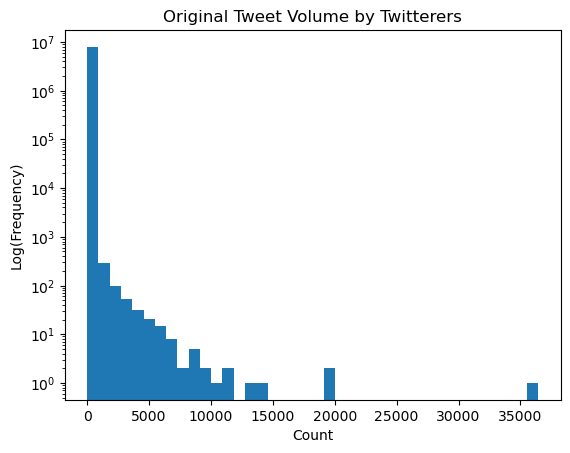

In [44]:
plt.hist(bins[:-1], bins = bins, weights = counts)
plt.yscale('log')
plt.ylabel('Log(Frequency)')
plt.xlabel('Count')
plt.title('Original Tweet Volume by Twitterers')
plt.show()

In [45]:
# Distribution of original retweet volume
bins, counts = twitterers_retweet.select('retweets_max').rdd.flatMap(lambda x: x).histogram(40)

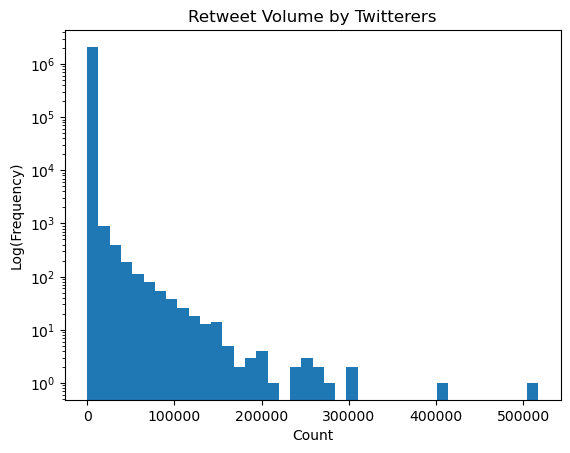

In [46]:
plt.hist(bins[:-1], bins = bins, weights = counts)
plt.yscale('log')
plt.ylabel('Log(Frequency)')
plt.xlabel('Count')
plt.title('Retweet Volume by Twitterers')
plt.show()

### By Types of Organizations

In [47]:
# Based on original tweet volume
org_df = twitterers_org_top_grouped.select('id', 'group')\
            .join(twitterers_org_top, twitterers_org_top_grouped['id'] == twitterers_org_top['id'], how = 'inner')
org_df.limit(10)

id,group,id,org_count
4725001,other,4725001,1184
10802042,other,10802042,578
15381455,other,15381455,589
19811171,news_outlets,19811171,588
70040425,other,70040425,588
85601740,other,85601740,687
93203454,other,93203454,2514
158890288,nonprofit_organiz...,158890288,579
199662147,other,199662147,891
312416857,other,312416857,790


In [48]:
p_org_df = org_df.groupBy('group').sum('org_count').toPandas()
p_org_df.head()

,group,sum(org_count)
0,schools,119299
1,social_media_influencers,159817
2,universities,83220
3,government_entities,16937
4,other,1161719


Text(0.5, 1.0, 'Original Tweet Volume by Types of Organization')

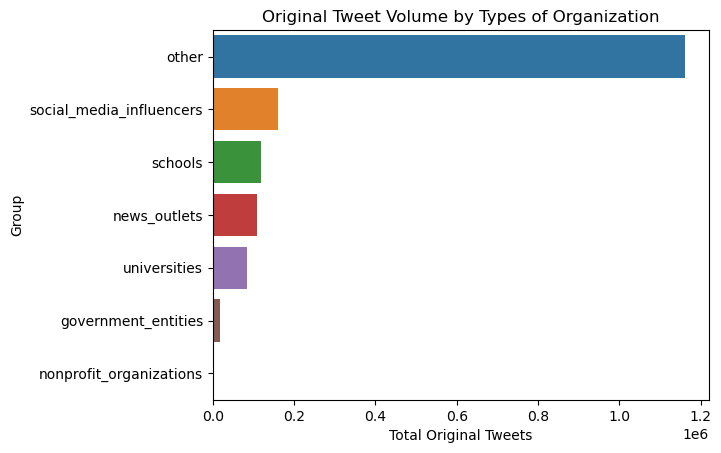

In [49]:
sns.barplot(y = 'group', x = 'sum(org_count)', data = p_org_df, orient = 'h', 
            order = p_org_df.sort_values('sum(org_count)',ascending = False).group)
plt.xlabel('Total Original Tweets')
plt.ylabel('Group')
plt.title('Original Tweet Volume by Types of Organization')

In [50]:
# Based on retweet volume
retweet_df = twitterers_retweet_top_grouped.select('id', 'group')\
            .join(twitterers_retweet_top, twitterers_retweet_top_grouped['id'] == twitterers_retweet_top['id'], how = 'inner')
retweet_df.limit(10)

id,group,id,retweets_max
15090092,government_entities,15090092,35298
15723081,government_entities,15723081,31135
16331010,news_outlets,16331010,44771
17633923,other,17633923,38383
18563202,other,18563202,35334
19771317,social_media_infl...,19771317,26504
21543404,government_entities,21543404,98721
21586418,other,21586418,53294
24460731,other,24460731,60779
25644400,social_media_infl...,25644400,81222


In [51]:
p_retweet_df = retweet_df.groupBy('group').sum('retweets_max').toPandas()
p_retweet_df.head()

,group,sum(retweets_max)
0,schools,887479
1,social_media_influencers,5006988
2,universities,1440422
3,government_entities,1351911
4,other,46382815


Text(0.5, 1.0, 'Retweet Volume by Types of Organization')

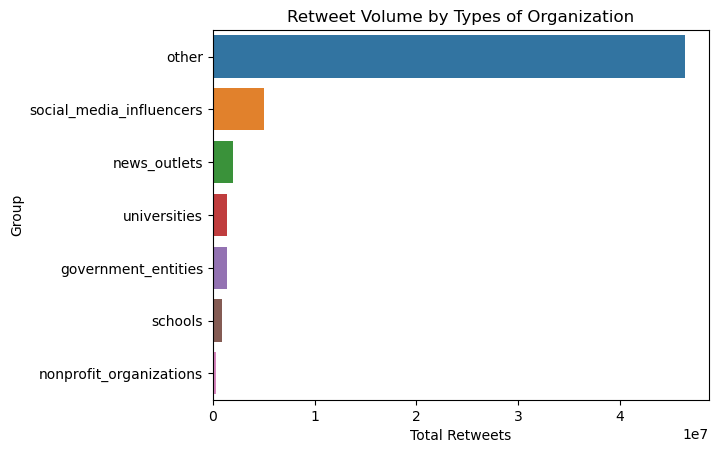

In [52]:
sns.barplot(y = 'group', x = 'sum(retweets_max)', data = p_retweet_df, orient = 'h', 
            order = p_retweet_df.sort_values('sum(retweets_max)',ascending = False).group)
plt.xlabel('Total Retweets')
plt.ylabel('Group')
plt.title('Retweet Volume by Types of Organization')